In [234]:
#Imports 

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as scilin
from pylab import rcParams, savefig
rcParams['figure.figsize'] = 24, 12

import warnings; warnings.simplefilter('ignore')

### Constants

In [3]:
# Orbit Params
orbitAlt = 450 # Orbit altitude [km]
rE = 6378 # Earth radius [km]
mu = 3.986e5 # Earth gravitational paramter [km^3/s^2]
omegaE = np.rad2deg(7.2921159e-5) # Earth rotational rate [deg/s]

orbitRad = rE + orbitAlt # [km]
thetaDot = np.rad2deg(np.sqrt(mu/orbitRad**3)) # Orbit angular rate (circular orbit) [deg/s]
orbitPeriod = 2*np.pi*np.sqrt(orbitRad**3/mu) # [seconds]

# Geomagnetic Params
M = 7.838e6 # dipole moment [Tkm^3]
gammaM = 17 # dipole tilt angle [degrees]

# Initial LEO Angles
orbitRAAN = 0 # [degrees]
orbitInc = 45 # [degrees]
theta_t0 = 0 # [degrees]

# Spacecraft Params
m = 30 # Spacecraft mass [kg]

# Spacecraft Initial Rotational Info (B rel. to N)
MRP0 = np.array([0.3, 0.2, 0.4]) # Initial attitude, MRPs
omegaVec0 = np.array([15, 8, 12]) # Initial omega IN B FRAME, [deg/s]
scInertia_B = np.array([
    [3.5, 0, 0],
    [0, 5, 0],
    [0, 0, 8]
]) # Inertia matrix IN B FRAME

### Useful Functions

In [4]:
# Tilde Matrix from Vector

def tildeMat(vector):
    
    tildeMat = np.array([
        [0, -vector[2], vector[1]],
        [vector[2], 0, -vector[0]],
        [-vector[1], vector[0], 0]
    ])
    
    return tildeMat

In [5]:
# 313 DCM Function

def DCM313(RAAN, inc, theta):
    
    R = np.deg2rad(RAAN)
    i = np.deg2rad(inc)
    th = np.deg2rad(theta)
    
    DCM313 = np.empty([3,3])
    
    DCM313[0,0] = np.cos(th)*np.cos(R) - np.sin(th)*np.cos(i)*np.sin(R)
    DCM313[0,1] = np.cos(th)*np.sin(R) + np.sin(th)*np.cos(i)*np.cos(R)
    DCM313[0,2] = np.sin(th)*np.sin(i)
    
    DCM313[1,0] = -np.sin(th)*np.cos(R) - np.cos(th)*np.cos(i)*np.sin(R)
    DCM313[1,1] = -np.sin(th)*np.sin(R) + np.cos(th)*np.cos(i)*np.cos(R)
    DCM313[1,2] = np.cos(th)*np.sin(i)
    
    DCM313[2,0] = np.sin(i)*np.sin(R)
    DCM313[2,1] = -np.sin(i)*np.cos(R)
    DCM313[2,2] = np.cos(i)
    
    return(DCM313)

In [6]:
# MRP DCM Function

def DCMMRP(sigmaVec):
    sigmaSquared = np.transpose(sigmaVec)@sigmaVec
    sigmaTilde = tildeMat(sigmaVec)
    #
    DCMMRP = np.eye(3) + (8*sigmaTilde@sigmaTilde - 4*(1-sigmaSquared)*sigmaTilde)/((1+sigmaSquared)**2)
    
    return(DCMMRP)

In [17]:
# RK4 Integrator

# RK4 integrator for attitude and attitude rate
# Uses MRPs for attitude description
# State vector is [sigma_BN
#                  omega_BN]

def RK4Attitude(f, ICs, timeEndPoints, h):
    t0 = timeEndPoints[0]
    tf = timeEndPoints[-1] + h
    numSteps = int(np.ceil((tf-t0)/h))
    
    dim = len(ICs)
    stateHistory = np.empty((dim, numSteps))
    
    t = t0
    state = ICs
    
    for i in range(0, numSteps):
        
        stateHistory[:,i] = state
        
        k1 = f(t, state)
        k2 = f(t+h*0.5, state+h*k1*0.5)
        k3 = f(t+h*0.5, state+h*k2*0.5)
        k4 = f(t+h, state+h*k3)
        
        state = state + h/6*(k1 + 2*k2 + 2*k3 + k4)
        
        # Switch to shadow set for MRPs
        sigma = state[0:3] # First 3 elements of state are elements of MRP vector
        if abs(np.linalg.norm(sigma)-1) <= 1e-16:
            sigma = -sigma/(np.linalg.norm(sigma)**2)
            state[0:3] = sigma # Put switched MRP back into state vector
        elif np.linalg.norm(sigma) >= 1:
            sigma = -sigma/(np.linalg.norm(sigma)**2)
            state[0:3] = sigma # Put switched MRP back into state vector
            
        t = t + h
    
    return stateHistory

In [18]:
# Attitude (and omega) First Order DE

def fullAttitudeDE(t, X, info):
    # Unpack info
    I = info[0]
    T = info[1]
    
    # Unpack state vector
    MRPs = X[0:3]
    omegaVec = X[3:6]
    
    # MRP Kinematic DE
    sigma = np.linalg.norm(MRPs)
    AMat = np.array([
        [1 - sigma**2 + 2*MRPs[0]**2, 2*(MRPs[0]*MRPs[1] - MRPs[2]), 2*(MRPs[0]*MRPs[2] + MRPs[1])],
        [2*(MRPs[1]*MRPs[0] + MRPs[2]), 1 - sigma**2 + 2*MRPs[1]**2, 2*(MRPs[1]*MRPs[2] - MRPs[0])],
        [2*(MRPs[2]*MRPs[0] - MRPs[1]), 2*(MRPs[2]*MRPs[1] + MRPs[0]), 1 - sigma**2 + 2*MRPs[2]**2]
    ])
    
    MRPsDot = 0.25*AMat@omegaVec
    
    # Omega DE
    omegaTilde = tildeMat(omegaVec)
    omegaVecDot = scilin.inv(I)@(np.cross(-omegaVec, I@omegaVec) + T)
    
    # Repack into 6x1
    XDot = np.concatenate((MRPsDot, omegaVecDot), axis=0)
    
    return XDot

## Project Milestones
### Coordinate Frame Relations

### Numerical Integrator

In [183]:
# Integrator setup

tSpan = [0, orbitPeriod]
h = 1 # time step, [s]

# Params for scenario
torqueVec = np.array([0, 0, 0]) # This should be in B frame
info = [scInertia_B, torqueVec]
ICs_Overview = np.concatenate((MRP0, np.deg2rad(omegaVec0)), axis=0)

# Integrate
odefunc = lambda t, X: fullAttitudeDE(t, X, info)
results = RK4Attitude(odefunc, ICs_Overview, tSpan, h)

tVec = np.arange(tSpan[0], tSpan[-1]+h, h)

In [184]:
# Look at angular momentum and rotational kinetic energy

angMom_t = np.empty([len(results[0,:]),])
T_t = np.empty([len(results[0,:]),])

for i in range(0, len(results[0,:])):
    angMom_t[i] = np.linalg.norm(scInertia_B@results[3:6,i])
    T_t[i] = 0.5*np.linalg.norm(np.transpose(results[3:6,i])@scInertia_B@results[3:6,i])
    
angMom_0 = scInertia_B@np.deg2rad(omegaVec0)
angMom_f = scInertia_B@results[3:6,-1]

print(np.linalg.norm(angMom_0))
print(np.linalg.norm(angMom_f))

T_0 = 0.5*np.linalg.norm(np.transpose(np.deg2rad(omegaVec0))@scInertia_B@np.deg2rad(omegaVec0))
T_f = 0.5*np.linalg.norm(np.transpose(results[3:6,-1])@scInertia_B@results[3:6,-1])

print(T_0)
print(T_f)

2.033308578573394
2.03218419001423
0.344141530004034
0.3436473695311135


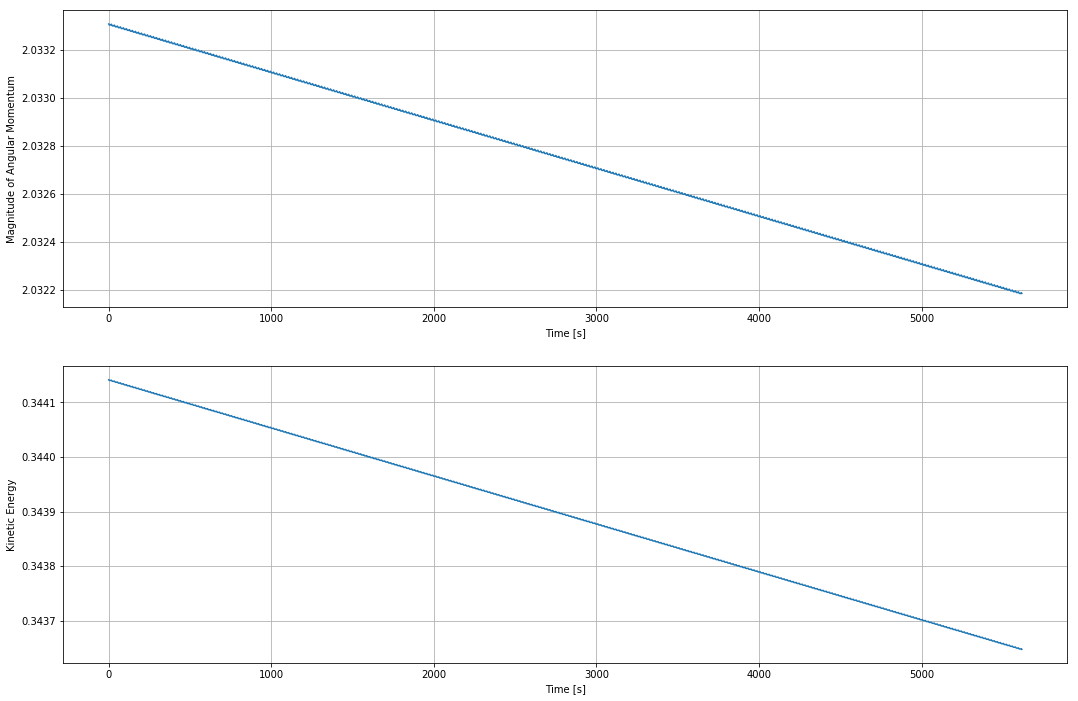

In [255]:
# Plot ang mom and energy over time

tSpan = [0, orbitPeriod]
tVec = np.arange(tSpan[0], tSpan[-1]+h, h)

plt.figure(figsize=(18,12))
plt.subplot(211)
plt.plot(tVec, angMom_t)
plt.ylabel('Magnitude of Angular Momentum')
plt.xlabel('Time [s]')
plt.grid()

plt.subplot(212)
plt.plot(tVec, T_t)
plt.ylabel('Kinetic Energy')
plt.xlabel('Time [s]')
plt.xlabel('Time [s]')
plt.grid()

plt.savefig('angMomEnergyCons.png', bbox_inches='tight')

### Geomagnetic Modeling

In [76]:
# Magnetic field function
#
# Returns magnetic field vector (in Hill frame) as a function of geometry and time

def magField(info, eulerAngs, thetaDot, beta0, t):
    
    # Unpack info
    M = info[0] # Magnetic dipole moment
    r = info[1] # Orbit radius
    gamma = np.deg2rad(info[2]) # Tilt angle between inertial and geomagnetic frames
    omegaE = info[3] # STILL IN DEGREES/s HERE
    
    # Convert angles to radians
    RAAN = np.deg2rad(eulerAngs[0])
    inc = np.deg2rad(eulerAngs[1])
    theta = np.deg2rad(eulerAngs[2])
    thetaDot = np.deg2rad(thetaDot)
    
    # Compute beta
    beta = np.deg2rad(beta0 + omegaE*t)
    
    # Compute xi_m, eta_m
    xi_m = np.arccos(np.cos(inc)*np.cos(gamma) + np.sin(inc)*np.sin(gamma)*np.cos(RAAN - beta))
    eta_m = np.arcsin(np.sin(gamma)*np.sin(RAAN - beta)/np.sin(xi_m))
    
    # Compute magnetic field vector (units of Teslas)
    bVec_HFrame = M/r**3*np.asarray([
        np.cos(thetaDot*t - eta_m)*np.sin(xi_m),
        np.cos(xi_m),
        -2*np.sin(thetaDot*t - eta_m)*np.sin(xi_m)
    ])
    
    # Return
    return(bVec_HFrame)

#### Local magnetic field $^H\mathbf{b}$ in orbit frame (Hill frame):

In [78]:
# Compute one orbit period

tStep = 1 # Timestep for computing magnetic field
timeOrbitPeriod = np.linspace(0, orbitPeriod, int(np.ceil(orbitPeriod/tStep)))

# Array to store magnetic field over time
magVec_HFrame_orbitPeriod = np.empty((3, int(np.ceil(orbitPeriod/tStep))))

print(magVec_HFrame_orbitPeriod.shape)

# Info for magnetic field function
info = [M, orbitRad, gammaM, omegaE]

for i in range(0, len(timeOrbitPeriod)):
    
    t = timeOrbitPeriod[i] # Time
    
    # Euler angles (time varying)
    eulerAngs = [orbitRAAN, orbitInc, theta_t0+thetaDot*t]
    
    magVec_HFrame_orbitPeriod[:,i] = magField(info, eulerAngs, thetaDot, 0, t)

(3, 5616)


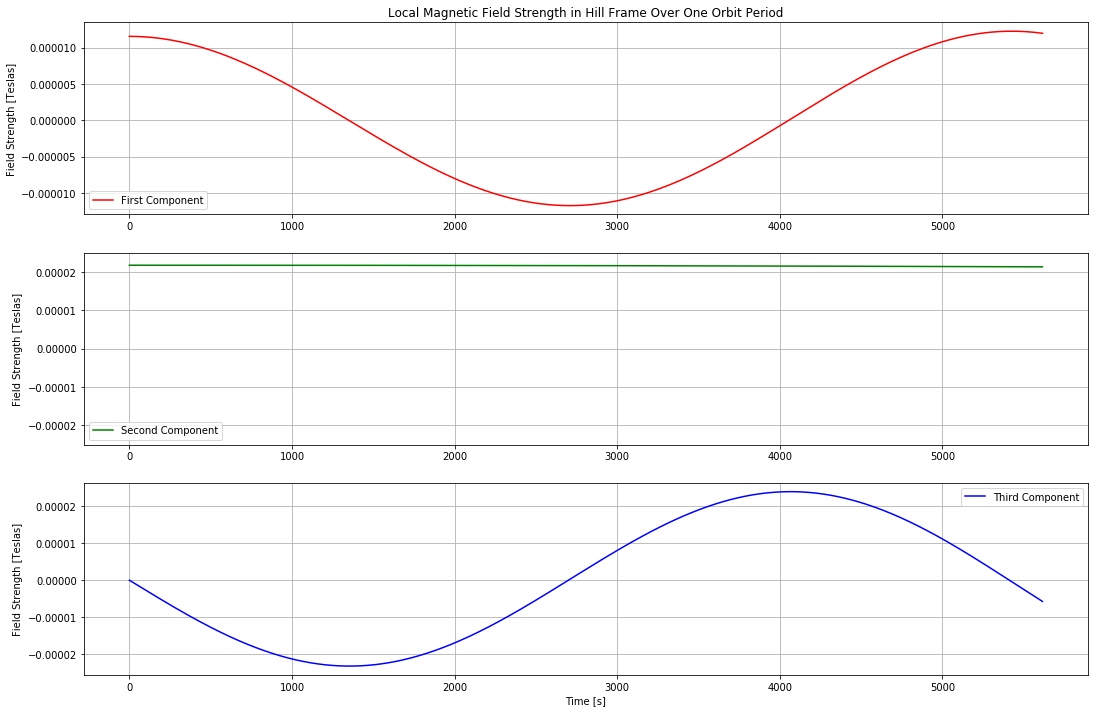

In [253]:
# Plot local magnetic field in Hill frame (over one orbit period)

plt.figure(figsize=(18,12))
plt.subplot(311)
plt.plot(timeOrbitPeriod, magVec_HFrame_orbitPeriod[0,:], 'r-', label='First Component')
plt.title('Local Magnetic Field Strength in Hill Frame Over One Orbit Period')
plt.legend()
plt.ylabel('Field Strength [Teslas]')
plt.grid()
plt.subplot(312)
plt.plot(timeOrbitPeriod, magVec_HFrame_orbitPeriod[1,:], 'g-', label='Second Component')
plt.ylim([-2.5e-5, 2.5e-5])
plt.legend()
plt.ylabel('Field Strength [Teslas]')
plt.grid()
plt.subplot(313)
plt.plot(timeOrbitPeriod, magVec_HFrame_orbitPeriod[2,:], 'b-', label='Third Component')
plt.xlabel('Time [s]')
plt.ylabel('Field Strength [Teslas]')
plt.legend()
plt.grid()

# Save figure
plt.savefig('BFieldHill.png', bbox_inches='tight')

plt.show()

#### Local Magnetic Field $^H\mathbf{b}$ in body frame

$$^B\mathbf{b} = \begin{bmatrix}BN\end{bmatrix} \begin{bmatrix}NH\end{bmatrix} ^H\mathbf{b}$$  

In [83]:
beta0 = 0 # [degrees]

# Array to store magnetic field vector in body frame over time
magVec_BFrame_100s = np.empty((3, len(tVec)))

info = [M, orbitRad, gammaM, omegaE]

beta0 = 0

for i in range(0, len(tVec)):
    
    t = tVec[i]
    
    BN = DCMMRP(results[0:3,i])
    NH = np.transpose(DCM313(orbitRAAN, orbitInc, theta_t0+thetaDot*t))
    
    # Euler angles (time varying)
    eulerAngs = [orbitRAAN, orbitInc, theta_t0+thetaDot*t]
    
    # Magnetic field vector in Hill frame
    magVec_HFrame = magField(info, eulerAngs, thetaDot, beta0, t)
    
    # Transform hill frame vector to body frame
    magVec_BFrame_100s[:,i] = BN@NH@magVec_HFrame

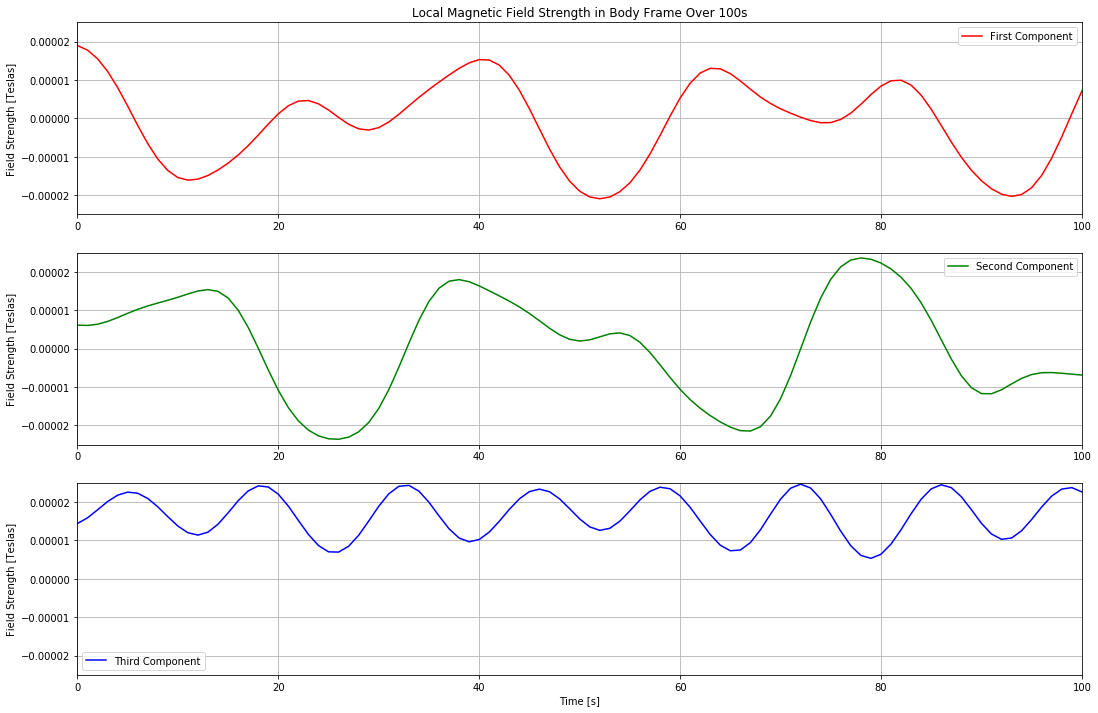

In [254]:
# Plot local magnetic field in body frame (over 100s)

plt.figure(figsize=(18,12))
plt.subplot(311)
plt.plot(tVec, magVec_BFrame_100s[0,:], 'r-', label='First Component')
plt.title('Local Magnetic Field Strength in Body Frame Over 100s')
plt.legend()
plt.grid()
plt.ylabel('Field Strength [Teslas]')
plt.ylim([-2.5e-5, 2.5e-5])
plt.xlim([0,100])
plt.subplot(312)
plt.plot(tVec, magVec_BFrame_100s[1,:], 'g-', label='Second Component')
plt.legend()
plt.grid()
plt.ylabel('Field Strength [Teslas]')
plt.ylim([-2.5e-5, 2.5e-5])
plt.xlim([0,100])
plt.subplot(313)
plt.plot(tVec, magVec_BFrame_100s[2,:], 'b-', label='Third Component')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Field Strength [Teslas]')
plt.legend()
plt.ylim([-2.5e-5, 2.5e-5])
plt.xlim([0,100])
plt.grid()

# Save figure
plt.savefig('BFieldBody.png', bbox_inches='tight')

plt.show()

## Control Law Implementation
### Modulating B-dot control law

Command dipole: $\mathbf{m}$  
$$\mathbf{m} = \frac{-k_{\omega}}{||\mathbf{b}||} \times [(I_{3x3} - \hat{\mathbf{b}}\hat{\mathbf{b}}^T)\mathbf{\omega}]$$  
$$k_{\omega} = 2\dot{\theta}(1+\sin{\xi_m})I_{\text{min}}$$  
$$\mathbf{u} = \mathbf{m} \times \mathbf{b}$$  
$$^{*}||\mathbf{m}||_{\text{max}} = 3\ Am^2$$  
Note that $\mathbf{b}$ is in body frame components.

In [282]:
# Attitude (and omega) First Order DE WITH CONTROL LAW
# 'controlLaw' is a function with arguments (t,X) that outputs a torque vector and command magnetic dipole

def fullAttitudeDEControl(t, X, info, controlLaw):
    # Unpack info
    I = info[0]
    T = info[1]
    
    # Unpack state vector
    MRPs = X[0:3]
    omegaVec = X[3:6]
    
    # MRP Kinematic DE
    sigma = np.linalg.norm(MRPs)
    
    AMat = ((1-sigma**2)*np.eye(3) + 2*tildeMat(MRPs) + 2*np.outer(MRPs, MRPs))
    
    MRPsDot = 0.25*AMat@omegaVec
    
    # Compute control torque
    u = controlLaw(t, X)[0]
    
    # Omega DE
    omegaTilde = tildeMat(omegaVec)
    omegaVecDot = scilin.inv(I)@(np.cross(-omegaVec, I@omegaVec) + u)
    
    # Repack into 6x1
    XDot = np.concatenate((MRPsDot, omegaVecDot), axis=0)
    
    return XDot

In [283]:
# Modulating B-dot control law

def modulatingBDot(t, X, mMax, info):
    
    # Unpack
    omegaE = info[0] # [deg/s]
    RAAN = info[1] # [deg]
    inc = info[2] # [deg]
    theta0 = info[3] # [deg]
    thetaDot = info[4] # [deg/s]
    orbitRad = info[5] # [km]
    inertiaMat = info[6]
    beta0 = info[7] # [deg]
    gamma = info[8] # [deg]
    M = info[9] # [Tkm^3]
    
    bHill = magField([M, orbitRad, gamma, omegaE], [RAAN, inc, theta0+thetaDot*t], thetaDot, beta0, t)
    
    BN = DCMMRP(X[0:3])
    NH = np.transpose(DCM313(RAAN, inc, theta0+thetaDot*t))
    
    # Transform hill frame vector to body frame
    bBody = BN@NH@bHill
    
    # Compute gain
    i = np.deg2rad(inc) # [rads]
    gam = np.deg2rad(gamma) # [rads]
    beta = np.deg2rad(beta0 + omegaE*t) # [rads]
    xi_m = np.arccos(np.cos(i)*np.cos(gam) + np.sin(i)*np.sin(gam)*np.cos(np.deg2rad(RAAN) - beta)) # [rads]
    
    IMin = np.amin(inertiaMat.diagonal())
    kw = 2*np.deg2rad(thetaDot)*(1+np.sin(xi_m))*IMin
    
    # Compute command dipole
    bBodyHat = bBody/np.linalg.norm(bBody)
    omegaVec = X[3:6]
    
    mVec = -1*kw/np.linalg.norm(bBody)*np.cross(bBodyHat, (np.eye(3) - np.outer(bBodyHat, bBodyHat))@omegaVec)
    
    # Check for saturation (componentwise)
    for i in range(0,3):
        if np.abs(mVec[i]) > mMax:
            mVec[i] = np.sign(mVec[i])*mMax
        
    # Compute control torque:
    uVec= np.cross(mVec, bBody)
    
    # Debugging
#     print('t is: ', t)
#     print('State is: ', X)
#     print('theta dot is: ', thetaDot)
#     print('Gain kw is: ', kw)
#     print('xi is [degrees]: ', np.rad2deg(xi_m))
#     print('m is: ', mVec)
#     print('b (body frame) is: ', bBody)
#     print('control torque vector u is: ', uVec, '\n')
    
    # Return
    return([uVec,mVec])

In [284]:
mMax = 3 # [Am^2]

# Initial Conditions
MRP_i1 = np.asarray([0.1, 0.1, 0.4])
omegaVec_i1 = np.asarray([1, 12, 1])
ICs_1 = np.concatenate((MRP_i1, np.deg2rad(omegaVec_i1)), axis=0)

MRP_i2 = np.asarray([0.35, 0.2, 0.15])
omegaVec_i2 = np.asarray([6, 4, 13])
ICs_2 = np.concatenate((MRP_i2, np.deg2rad(omegaVec_i2)), axis=0)

controlParams = [omegaE, orbitRAAN, orbitInc, theta_t0, thetaDot, orbitRad, scInertia_B, beta0, gammaM, M]

externalTorque = np.asarray([0, 0, 0])

In [285]:
# Bang-Bang B-dot control law

def bangBangBDot(t, X, mMax, info):
    
    # Unpack
    omegaE = info[0] # [deg/s]
    RAAN = info[1] # [deg]
    inc = info[2] # [deg]
    theta0 = info[3] # [deg]
    thetaDot = info[4] # [deg/s]
    orbitRad = info[5] # [km]
    inertiaMat = info[6]
    beta0 = info[7] # [deg]
    gamma = info[8] # [deg]
    M = info[9] # [Tkm^3]
    
    # Rotation matrices
    BN = DCMMRP(X[0:3])
    NH = np.transpose(DCM313(RAAN, inc, theta_t0+thetaDot*t))
    
    # Magnetic field vector calculation
    bHill = magField([M, orbitRad, gamma, omegaE], [RAAN, inc, theta0+thetaDot*t], thetaDot, beta0, t)
    bBody = BN@NH@bHill
    
    i = np.deg2rad(inc)
    gam = np.deg2rad(gamma)
    Omega = np.deg2rad(RAAN)
    omega = np.deg2rad(omegaE)
    beta = np.deg2rad(beta0 + omegaE*t)
    
    # Compute time derivative of b as seen by H frame
    xi_m = np.arccos(np.cos(i)*np.cos(gam) + np.sin(i)*np.sin(gam)*np.cos(Omega-beta))
    eta_m = np.arcsin(np.sin(gam)*np.sin(Omega-beta)/np.sin(xi_m))
    
    xi_mPrime = -(-np.sin(i)*np.sin(gam)*np.sin(Omega-beta)*(-omega))/np.sqrt(1-(np.cos(i)*np.cos(gam)+np.sin(i)*np.sin(gam)*np.cos(Omega-beta))**2)
    
    eta_mPrime = 1/np.sqrt(1-(np.sin(gam)*np.sin(Omega-beta)/np.sin(xi_m))**2)*((np.sin(xi_m)*np.sin(gam)*np.cos(Omega-beta)*(-omega) - np.sin(gam)*np.sin(Omega-beta)*np.cos(xi_m)*xi_mPrime)/(np.sin(xi_m)**2))
    
    bPrimeRelHBody = (M/orbitRad**3)*BN@NH@np.asarray([
        -np.sin(thetaDot*t-eta_m)*(-eta_mPrime)*np.sin(xi_m) + np.cos(thetaDot*t-eta_m)*np.cos(xi_m)*xi_mPrime,
        -np.sin(xi_m)*xi_mPrime,
        -2*np.cos(thetaDot*t-eta_m)*(-eta_mPrime)*np.sin(xi_m) - 2*np.sin(thetaDot*t-eta_m)*np.cos(xi_m)*xi_mPrime
    ])
    
    # Compute cross product term in transport thm (omega_H/B x b)
    omega_HNBody = BN@NH@np.asarray([0, 0, np.deg2rad(thetaDot)])
    omega_BNBody = X[3:6]
    
    omega_HBBody = omega_HNBody - omega_BNBody
    
    # Compute b'
    bPrimeRelBBody = bPrimeRelHBody + np.cross(omega_HBBody, bBody)
    
    # Compute m
    mBody = -1*mMax*np.sign(bPrimeRelBBody)
    
    # Compute control torque u
    uBody = np.cross(mBody, bBody)
    
    # Debug
#     print('u is: ', uBody)
#     print('b is: ', bBody)
#     print('m is: ', mBody, '\n')
    
    # Return
    return([uBody,mBody])

### All Plots Below

#### 45 deg inclination, modulating+bang-bang, all 3 ICs

In [286]:
%%time

mMax = 3 # [Am^2]

# Initial Conditions
MRP_i1 = np.asarray([0.1, 0.1, 0.4])
omegaVec_i1 = np.asarray([1, 12, 1])
ICs_1 = np.concatenate((MRP_i1, np.deg2rad(omegaVec_i1)), axis=0)

MRP_i2 = np.asarray([0.35, 0.2, 0.15])
omegaVec_i2 = np.asarray([6, 4, 13])
ICs_2 = np.concatenate((MRP_i2, np.deg2rad(omegaVec_i2)), axis=0)

externalTorque = np.asarray([0, 0, 0])

controlParams = [omegaE, orbitRAAN, orbitInc, theta_t0, thetaDot, orbitRad, scInertia_B, beta0, gammaM, M]
 
controlFuncMod = lambda t, X: modulatingBDot(t, X, mMax, controlParams)
controlFuncBang = lambda t, X: bangBangBDot(t, X, mMax, controlParams)

odefuncMod = lambda t, X: fullAttitudeDEControl(t, X, [scInertia_B, externalTorque], controlFuncMod)
odefuncBang = lambda t, X: fullAttitudeDEControl(t, X, [scInertia_B, externalTorque], controlFuncBang)

tSpan = [0, 3*orbitPeriod]
tVec = np.arange(tSpan[0], tSpan[-1]+h, h)
h = 1 # time step, [s]

stepN = int(np.ceil((tSpan[-1]+h)/h))

ICsVec = [ICs_Overview, ICs_1, ICs_2]

resultsPart4 = np.empty((2,3,6,stepN))

for i in range(0,3):
    resultsPart4[0,i,:,:] = RK4Attitude(odefuncMod, ICsVec[i], tSpan, h) # modulating control
    resultsPart4[1,i,:,:] = RK4Attitude(odefuncBang, ICsVec[i], tSpan, h) # bang bang control
    

CPU times: user 2min 20s, sys: 28.1 ms, total: 2min 20s
Wall time: 2min 20s


In [287]:
%%time

# Compute control error and control torque
# (control error is just omega)

controlTorquesPart4 = np.empty((2,3,3,stepN))
controlDipolePart4 = np.empty((2,3,3,stepN))

# Compute torques
for i in range(0,3):
    for j in range(0,stepN):
        
        mod = controlFuncMod(tVec[j], resultsPart4[0,i,:,j])
        bang = controlFuncBang(tVec[j], resultsPart4[1,i,:,j])
        
        controlTorquesPart4[0,i,:,j] = mod[0] # modulating control torque
        controlTorquesPart4[1,i,:,j] = bang[0] # bang bang control torque
        controlDipolePart4[0,i,:,j] = mod[1] # modulating control moment dipole
        controlDipolePart4[1,i,:,j] = bang[1] # bang bang control moment dipole


CPU times: user 20.4 s, sys: 11.9 ms, total: 20.4 s
Wall time: 20.4 s


In [279]:
tSpan = [0, 3*orbitPeriod]
tVec = np.arange(tSpan[0], tSpan[-1]+h, h)

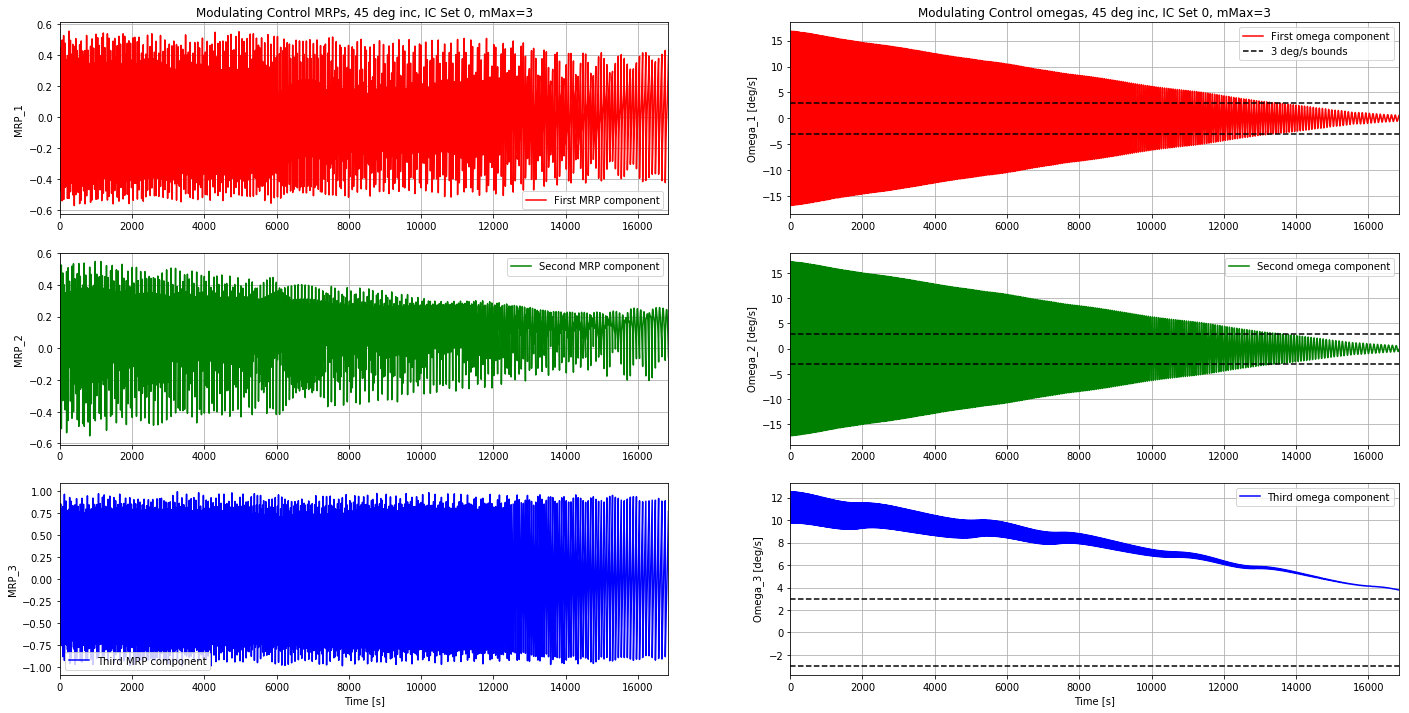

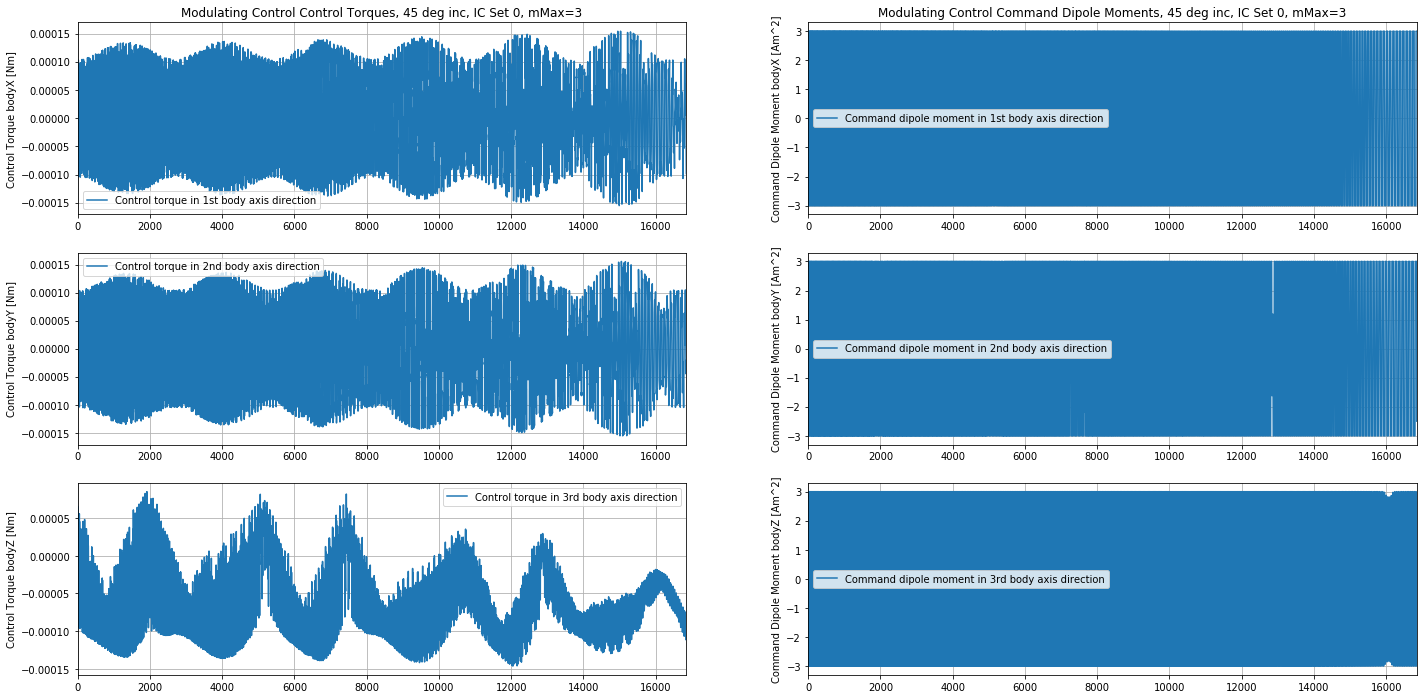

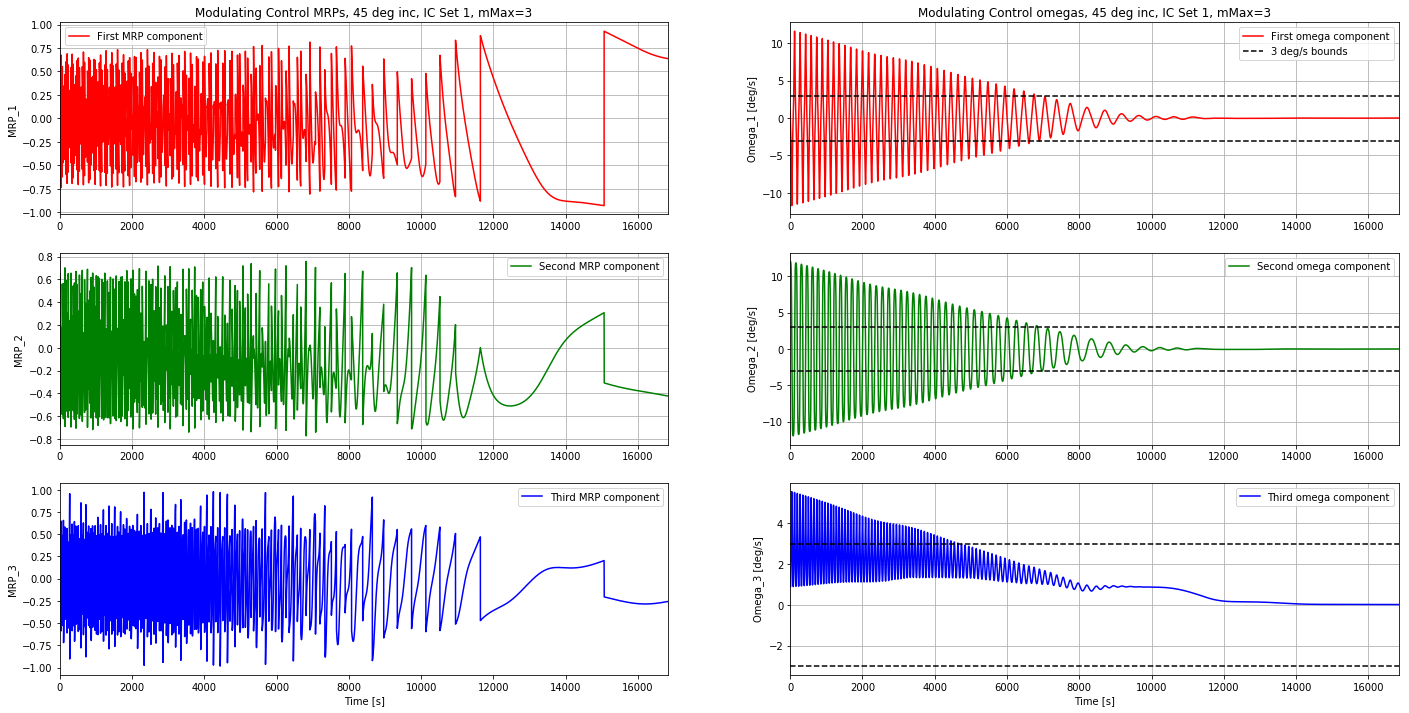

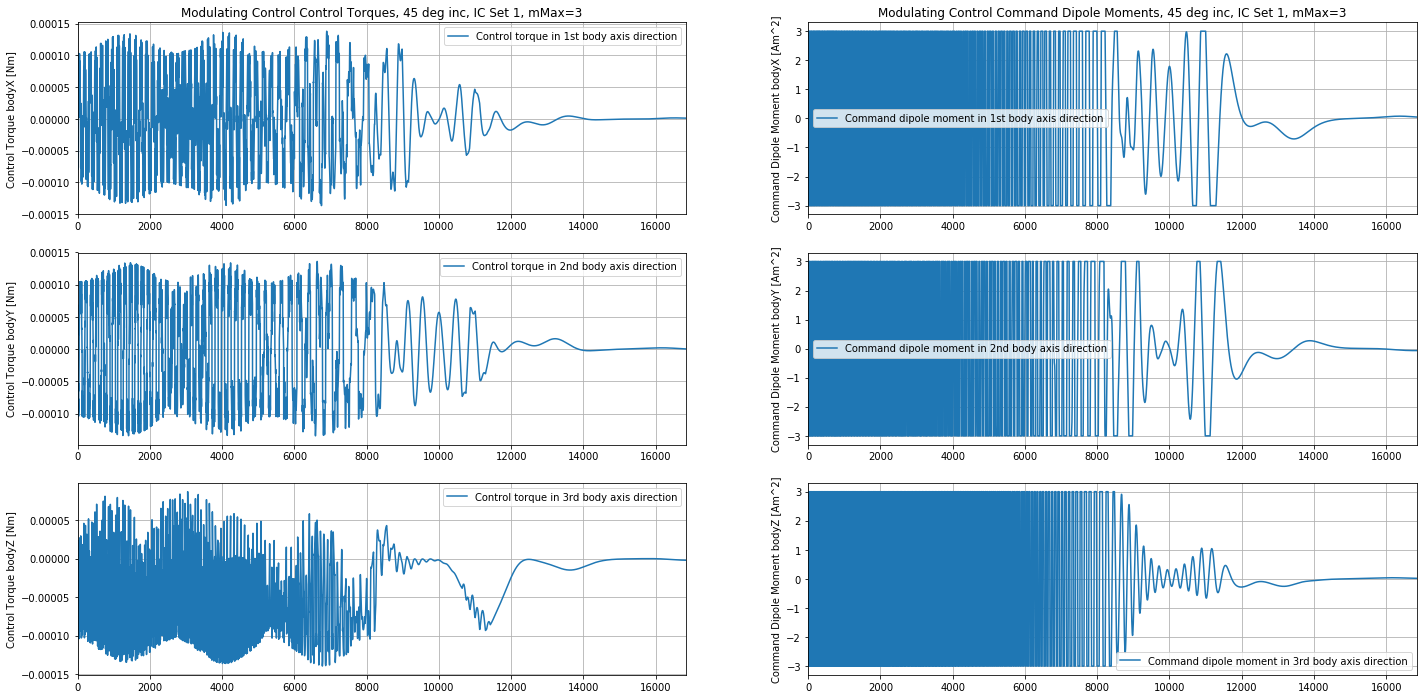

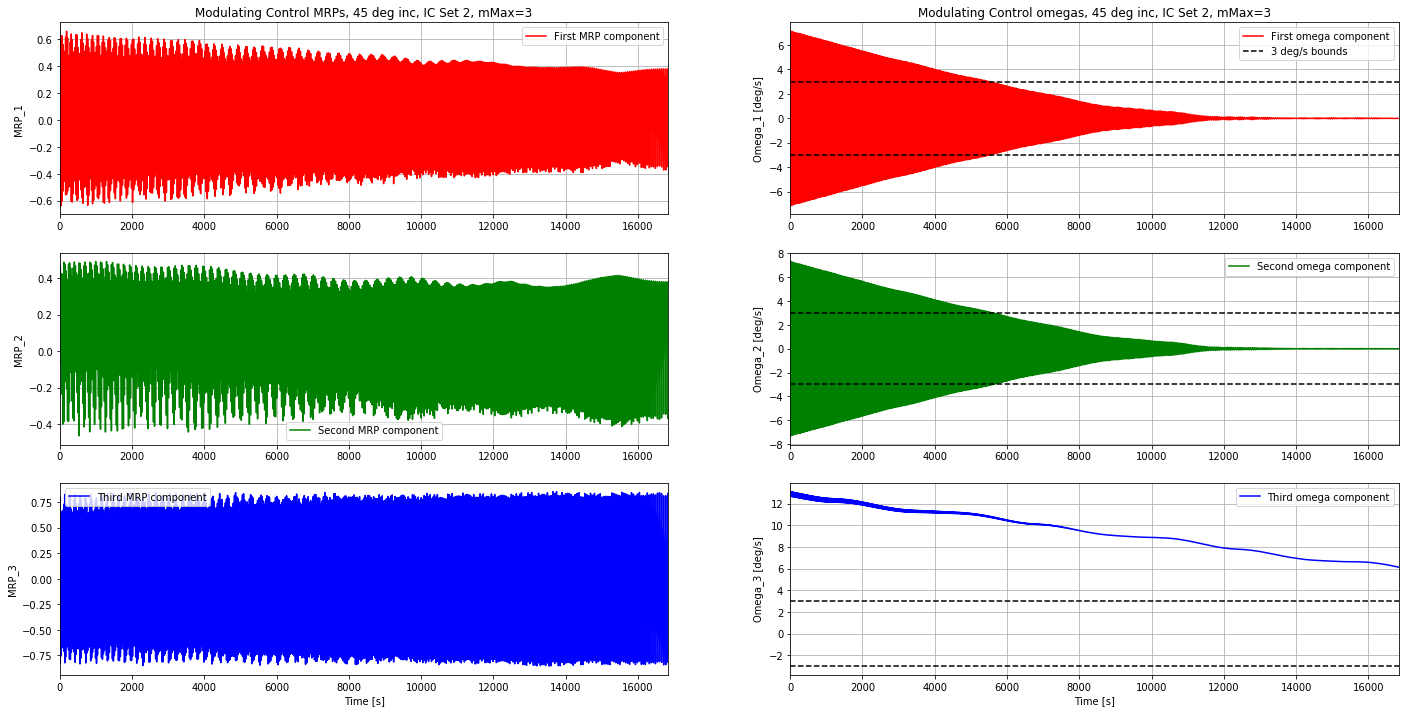

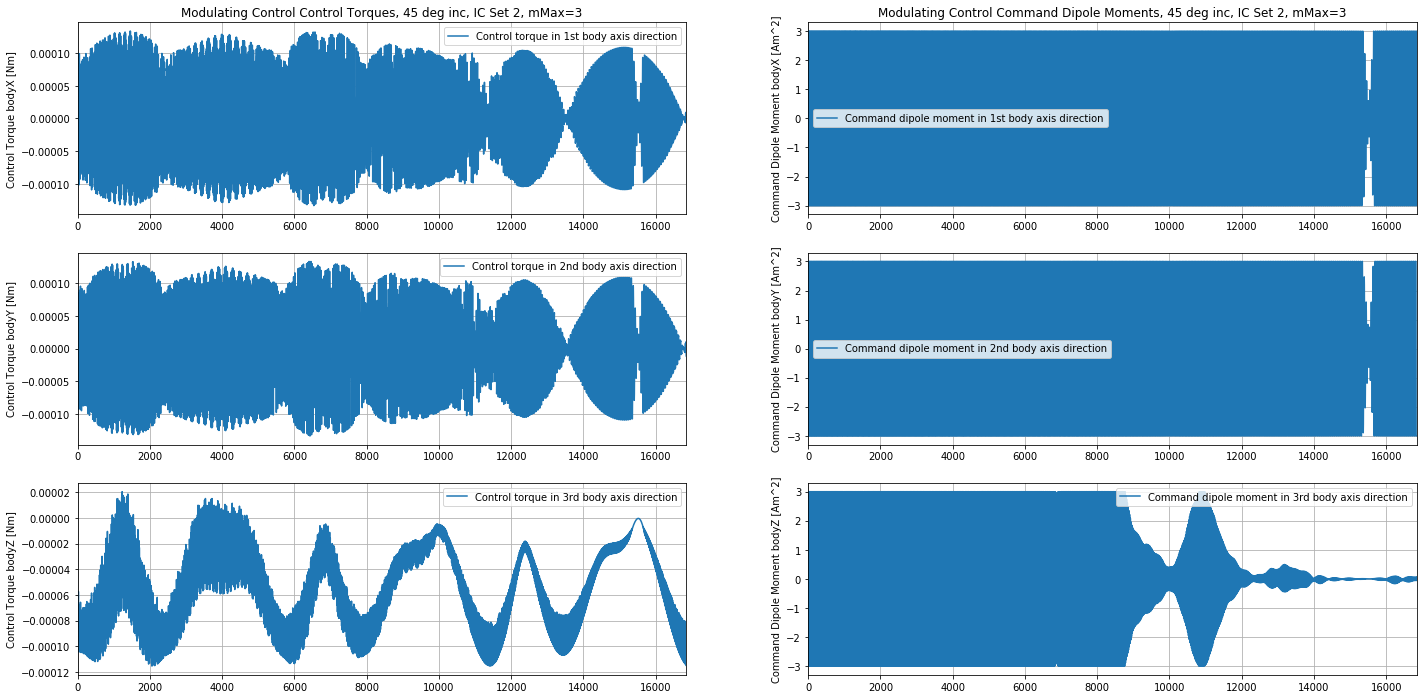

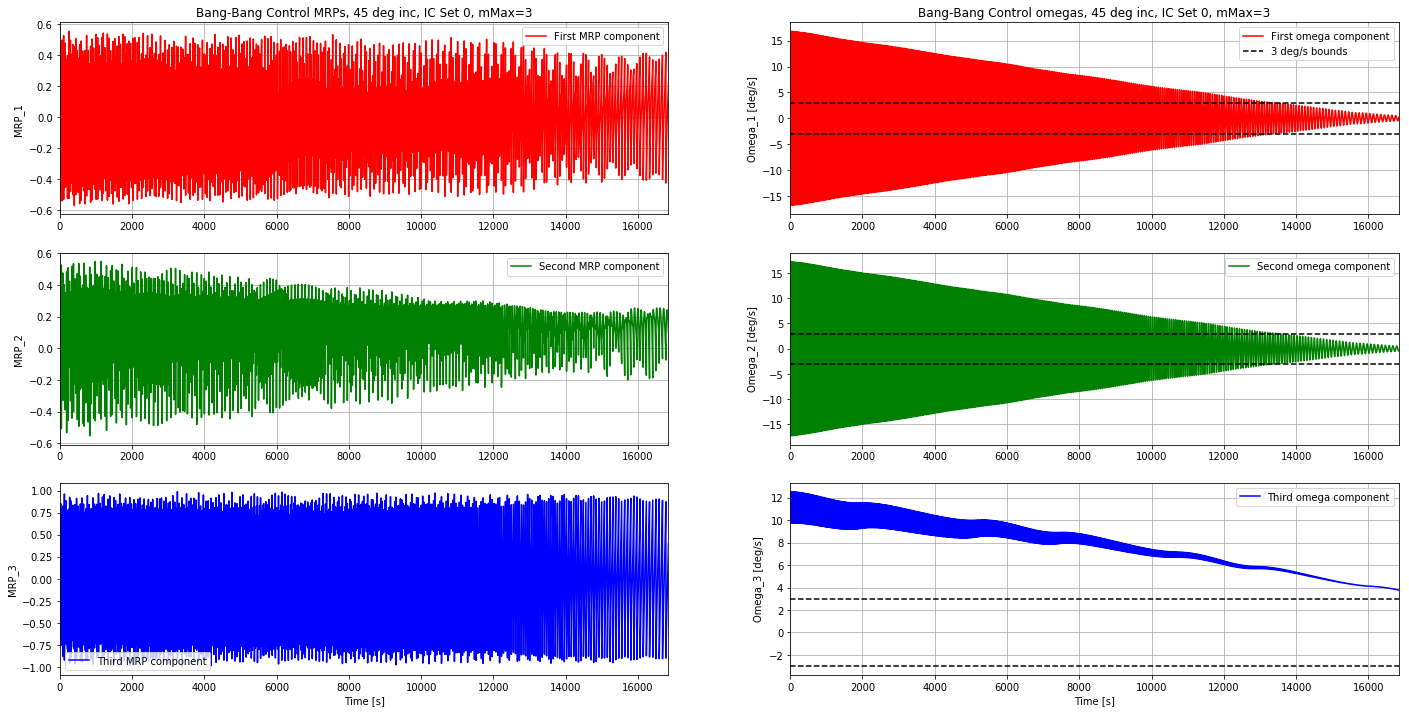

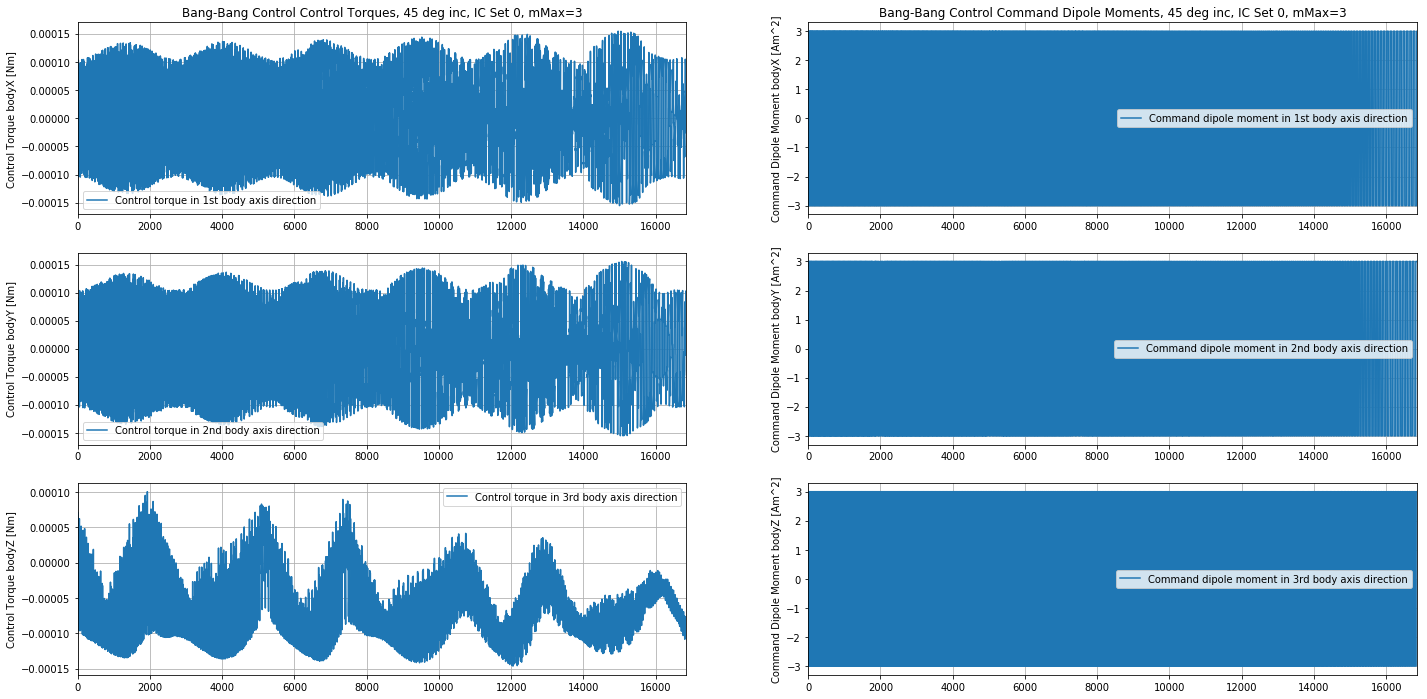

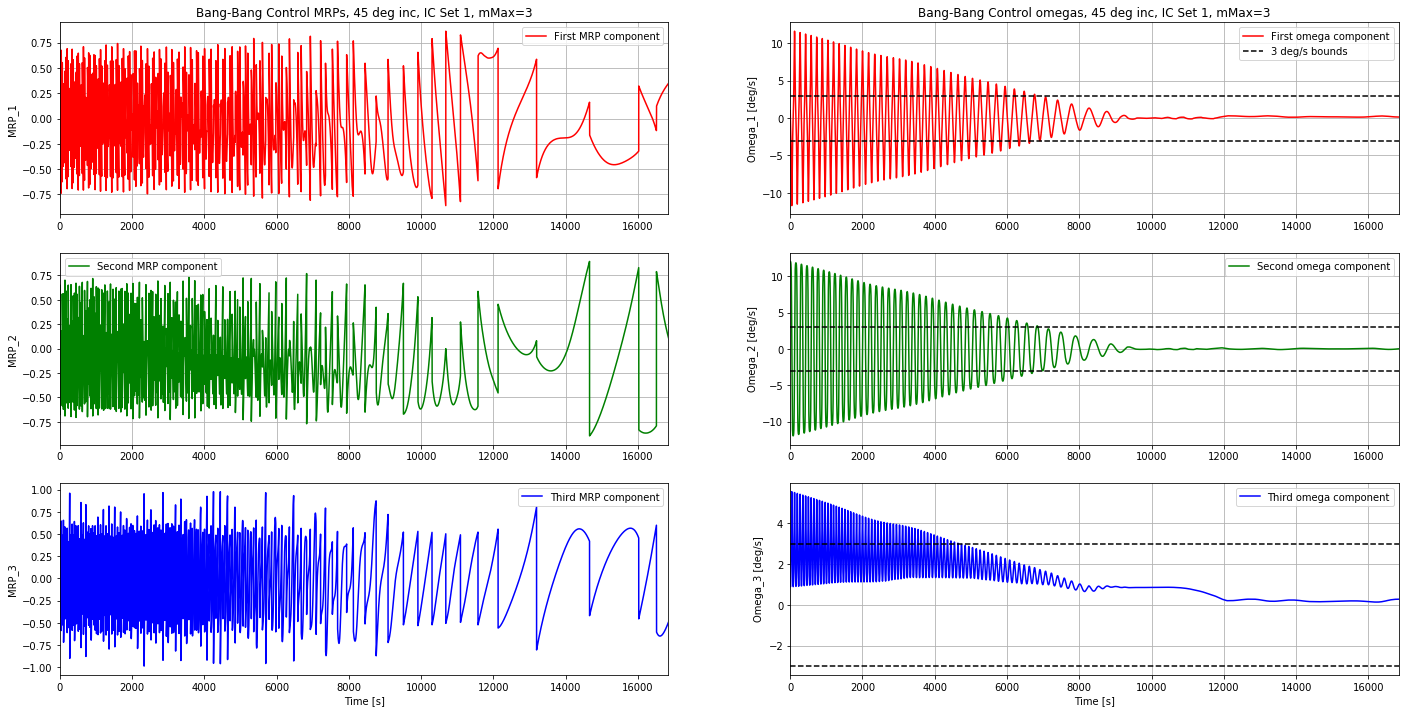

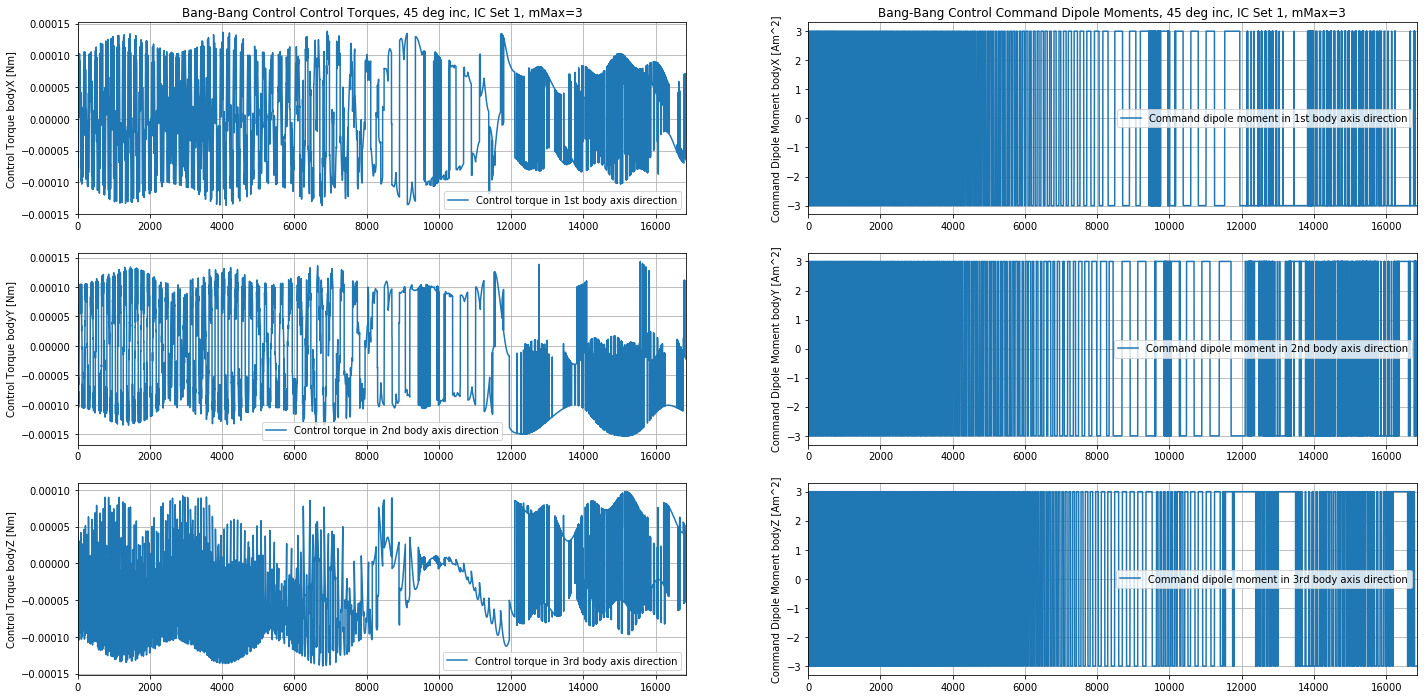

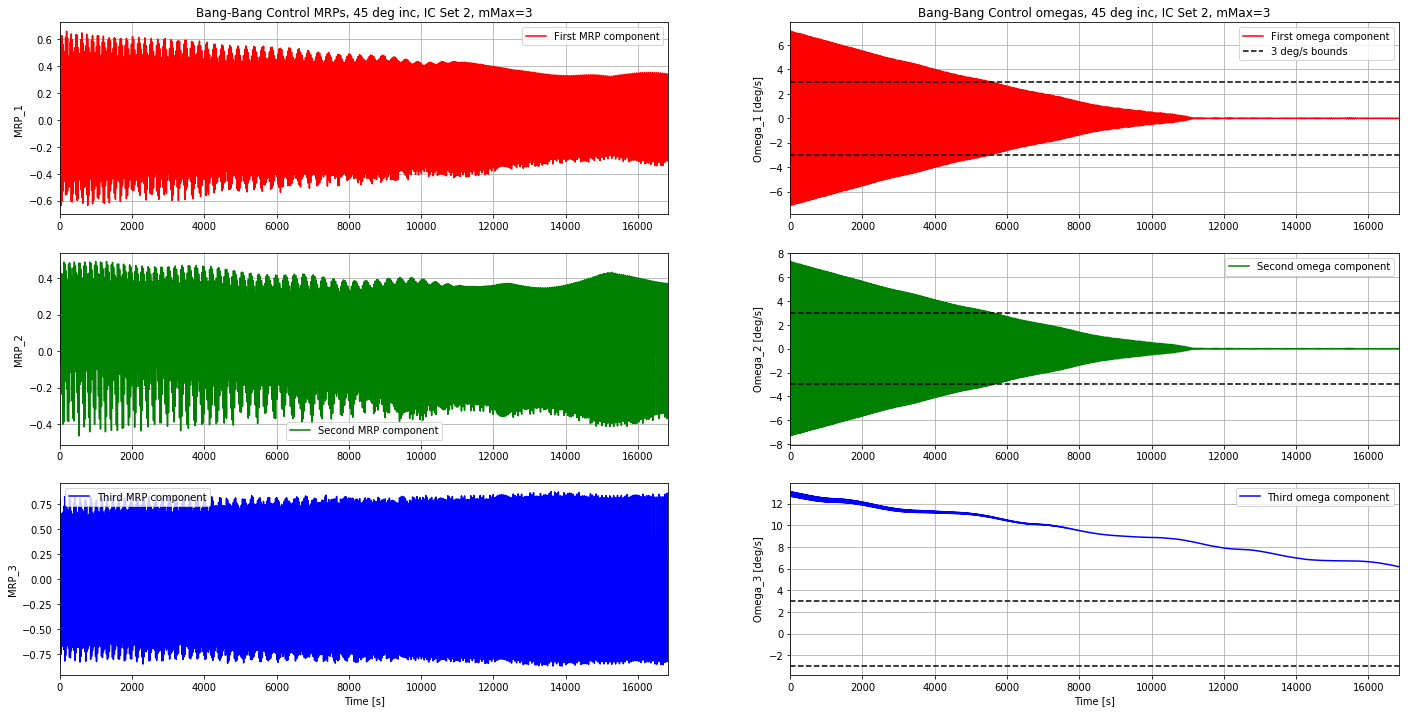

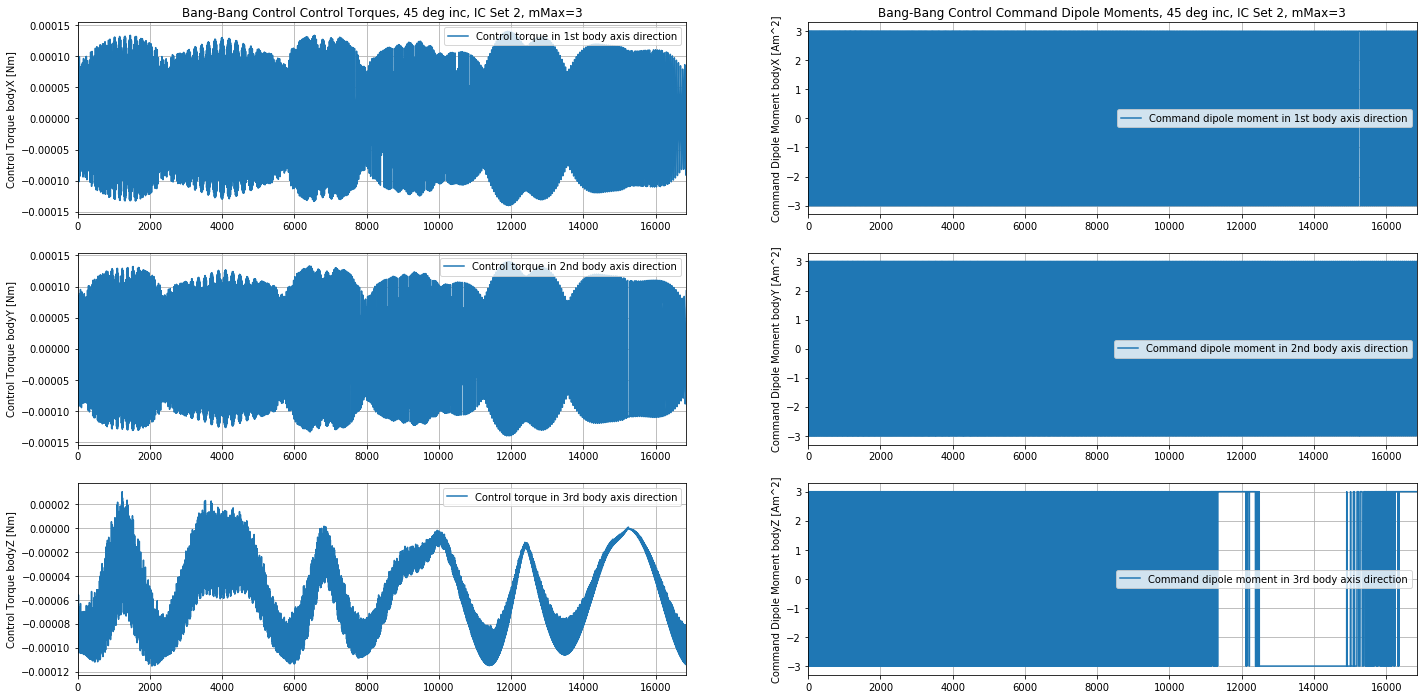

In [288]:
# All plots for part 4

controlTypes = ['Modulating Control', 'Bang-Bang Control']
for i in range(0,2): # loop over mod vs bang
    for j in range(0,3): # loop over ICs

        plt.figure()
        
        #Plot Omegas 
        plt.subplot(322)
        plt.plot(tVec, np.rad2deg(resultsPart4[i,j,3,:]), 'r-', label='First omega component')
        plt.plot([0,tSpan[-1]], [3,3], 'k--', label='3 deg/s bounds')
        plt.plot([0,tSpan[-1]], [-3,-3], 'k--')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('Omega_1 [deg/s]')
        plt.legend()
        plt.grid()
        plt.title(controlTypes[i]+' omegas, 45 deg inc, IC Set %i, mMax=3'%(j))
        plt.subplot(324)
        plt.plot(tVec, np.rad2deg(resultsPart4[i,j,4,:]), 'g-', label='Second omega component')
        plt.plot([0,tSpan[-1]], [3,3], 'k--')
        plt.plot([0,tSpan[-1]], [-3,-3], 'k--')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('Omega_2 [deg/s]')
        plt.legend()
        plt.grid()
        plt.subplot(326)
        plt.plot(tVec, np.rad2deg(resultsPart4[i,j,5,:]), 'b-', label='Third omega component')
        plt.plot([0,tSpan[-1]], [3,3], 'k--')
        plt.plot([0,tSpan[-1]], [-3,-3], 'k--')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('Omega_3 [deg/s]')
        plt.xlabel('Time [s]')
        plt.legend()
        plt.grid()
        
        #Plot MRPs
        plt.subplot(321)
        plt.plot(tVec, (resultsPart4[i,j,0,:]), 'r-', label='First MRP component')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('MRP_1')
        plt.legend()
        plt.grid()
        plt.title(controlTypes[i]+' MRPs, 45 deg inc, IC Set %i, mMax=3'%(j))
        plt.subplot(323)
        plt.plot(tVec, (resultsPart4[i,j,1,:]), 'g-', label='Second MRP component')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('MRP_2')
        plt.legend()
        plt.grid()
        plt.subplot(325)
        plt.plot(tVec, (resultsPart4[i,j,2,:]), 'b-', label='Third MRP component')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('MRP_3')
        plt.xlabel('Time [s]')
        plt.legend()
        
        # Save figures
        #plt.savefig(controlTypes[i]+'States45_IC%i_mMax3.png'%(j), bbox_inches='tight')
        
        # Plot control torque and magnetic dipole moment
        plt.figure()
        
        # Plot control torques first
        plt.subplot(321)
        plt.plot(tVec, controlTorquesPart4[i,j,0,:], label='Control torque in 1st body axis direction')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('Control Torque bodyX [Nm]')
        plt.legend()
        plt.grid()
        plt.title(controlTypes[i]+' Control Torques, 45 deg inc, IC Set %i, mMax=3'%(j))
        plt.subplot(323)
        plt.plot(tVec, controlTorquesPart4[i,j,1,:], label='Control torque in 2nd body axis direction')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('Control Torque bodyY [Nm]')
        plt.legend()
        plt.grid()
        plt.subplot(325)
        plt.plot(tVec, controlTorquesPart4[i,j,2,:], label='Control torque in 3rd body axis direction')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('Control Torque bodyZ [Nm]')
        plt.legend()
        plt.grid()
        
        # Plot command moment dipoles
        plt.subplot(322)
        plt.plot(tVec, controlDipolePart4[i,j,0,:], label='Command dipole moment in 1st body axis direction')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('Command Dipole Moment bodyX [Am^2]')
        plt.legend()
        plt.grid()
        plt.title(controlTypes[i]+' Command Dipole Moments, 45 deg inc, IC Set %i, mMax=3'%(j))
        plt.subplot(324)
        plt.plot(tVec, controlDipolePart4[i,j,1,:], label='Command dipole moment in 2nd body axis direction')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('Command Dipole Moment bodyY [Am^2]')
        plt.legend()
        plt.grid()
        plt.subplot(326)
        plt.plot(tVec, controlDipolePart4[i,j,2,:], label='Command dipole moment in 3rd body axis direction')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('Command Dipole Moment bodyZ [Am^2]')
        plt.legend()
        plt.grid()
        
        # Save figures
        #plt.savefig(controlTypes[i]+'Controls45_IC%i_mMax3.png'%(j), bbox_inches='tight')

#### 15 and 105 deg inclinations, only overview ICs

In [180]:
%%time

incVec = [15, 105] # inclination angles in degrees

mMax = 3
externalTorque = np.asarray([0, 0, 0])

tSpan = [0, 3*orbitPeriod]
tVec = np.arange(tSpan[0], tSpan[-1]+h, h)
h = 1 # time step, [s]

stepN = int(np.ceil((tSpan[-1]+h)/h))

ICsVec = [ICs_Overview, ICs_1, ICs_2]

resultsPart5a = np.empty((2,2,6,stepN))

for i in range(0,len(incVec)):
    
    controlParams = [omegaE, orbitRAAN, incVec[i], theta_t0, thetaDot, orbitRad, scInertia_B, beta0, gammaM, M]
    
    controlFuncMod = lambda t, X: modulatingBDot(t, X, mMax, controlParams)
    controlFuncBang = lambda t, X: bangBangBDot(t, X, mMax, controlParams)

    odefuncMod = lambda t, X: fullAttitudeDEControl(t, X, [scInertia_B, externalTorque], controlFuncMod)
    odefuncBang = lambda t, X: fullAttitudeDEControl(t, X, [scInertia_B, externalTorque], controlFuncBang)
    
    resultsPart5a[0,i,:,:] = RK4Attitude(odefuncMod, ICsVec[0], tSpan, h) # modulating
    resultsPart5a[1,i,:,:] = RK4Attitude(odefuncBang, ICsVec[0], tSpan, h) # bang-bang

CPU times: user 1min 33s, sys: 11.9 ms, total: 1min 33s
Wall time: 1min 33s


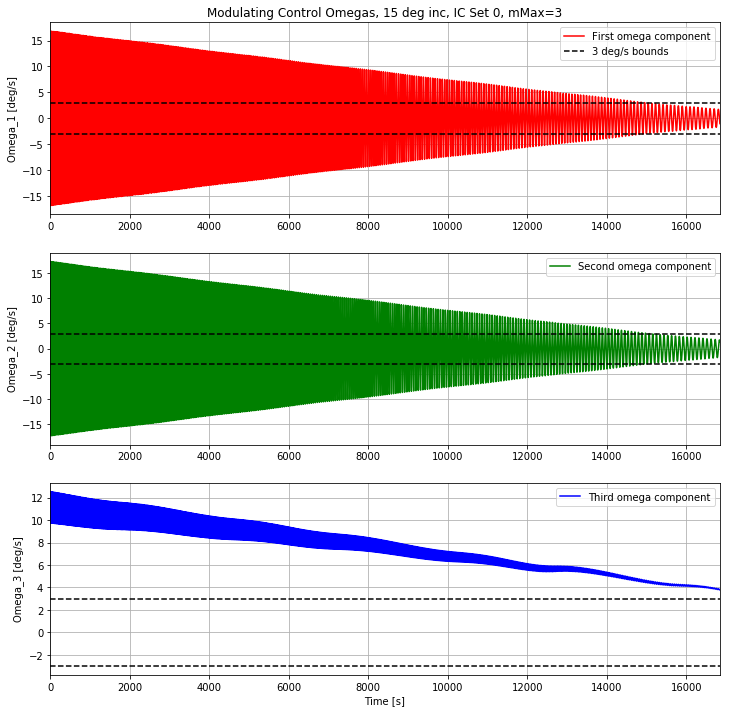

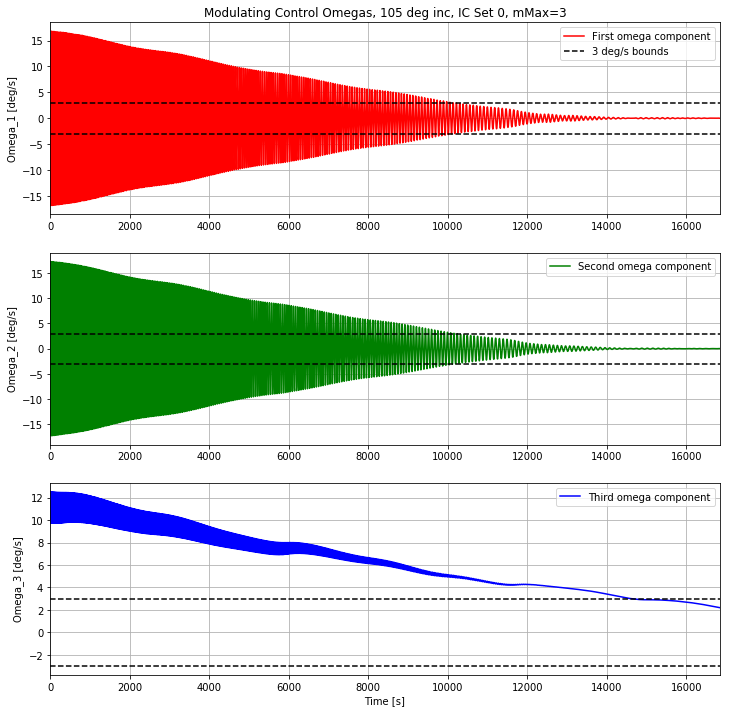

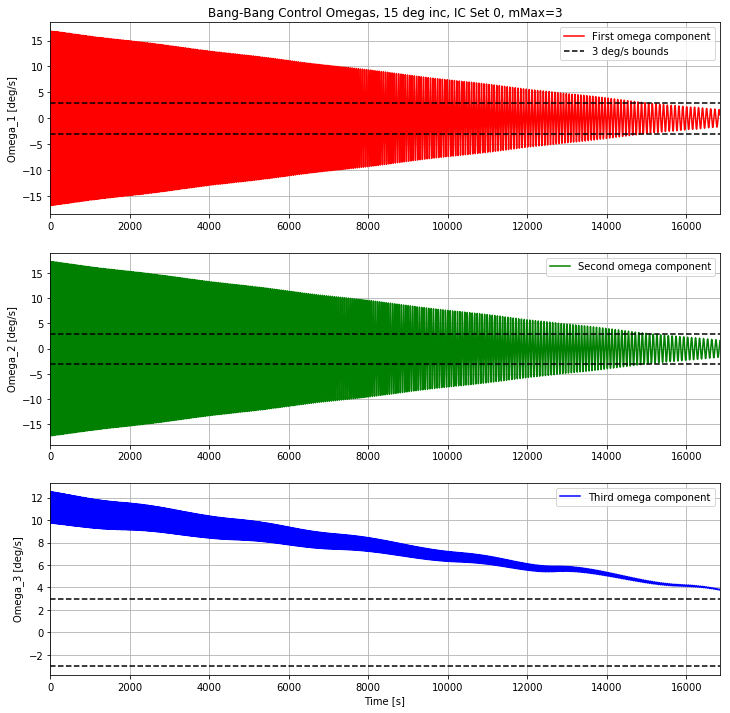

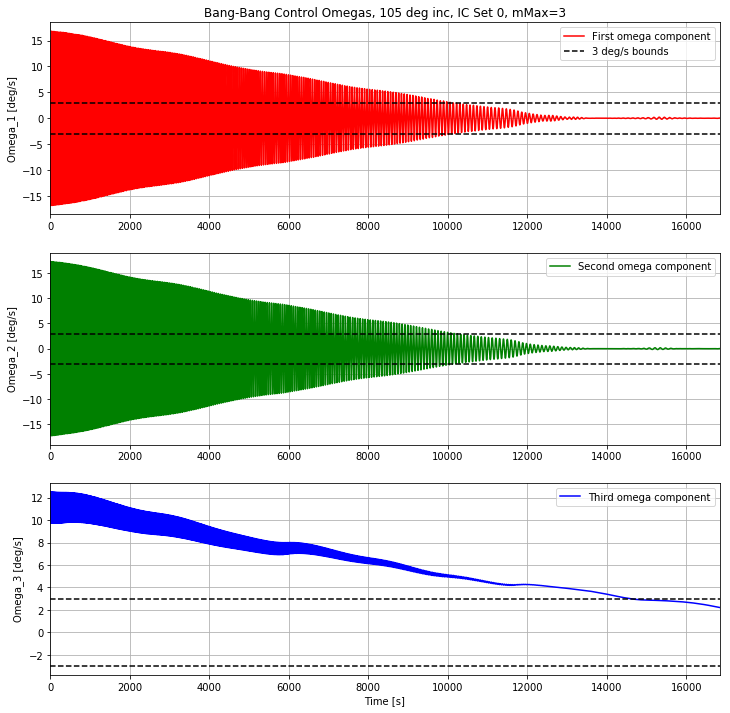

In [249]:
# Part a plots

for i in range(0,2):
    for j in range(0,2):
    
        plt.figure(figsize=(12,12))

        #Plot Omegas 
        plt.subplot(311)
        plt.plot(tVec, np.rad2deg(resultsPart5a[i,j,3,:]), 'r-', label='First omega component')
        plt.plot([0,tSpan[-1]], [3,3], 'k--', label='3 deg/s bounds')
        plt.plot([0,tSpan[-1]], [-3,-3], 'k--')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('Omega_1 [deg/s]')
        plt.legend()
        plt.grid()
        plt.title(controlTypes[i]+' Omegas, %i deg inc, IC Set 0, mMax=3'%(incVec[j]))
        plt.subplot(312)
        plt.plot(tVec, np.rad2deg(resultsPart5a[i,j,4,:]), 'g-', label='Second omega component')
        plt.plot([0,tSpan[-1]], [3,3], 'k--')
        plt.plot([0,tSpan[-1]], [-3,-3], 'k--')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('Omega_2 [deg/s]')
        plt.legend()
        plt.grid()
        plt.subplot(313)
        plt.plot(tVec, np.rad2deg(resultsPart5a[i,j,5,:]), 'b-', label='Third omega component')
        plt.plot([0,tSpan[-1]], [3,3], 'k--')
        plt.plot([0,tSpan[-1]], [-3,-3], 'k--')
        plt.xlim([0,tSpan[-1]])
        plt.ylabel('Omega_3 [deg/s]')
        plt.xlabel('Time [s]')
        plt.legend()
        plt.grid()
        
        plt.savefig(controlTypes[i]+'Omegas%i_IC0_mMax3.png'%(incVec[j]), bbox_inches='tight')

In [218]:
%%time

# 5b Stuff

mMaxMinMod = 4.205
mMaxMinBang = 4.05

controlParams = [omegaE, orbitRAAN, incVec[0], theta_t0, thetaDot, orbitRad, scInertia_B, beta0, gammaM, M]
    
controlFuncMod = lambda t, X: modulatingBDot(t, X, mMaxMinMod, controlParams)
controlFuncBang = lambda t, X: bangBangBDot(t, X, mMaxMinBang, controlParams)

odefuncMod = lambda t, X: fullAttitudeDEControl(t, X, [scInertia_B, externalTorque], controlFuncMod)
odefuncBang = lambda t, X: fullAttitudeDEControl(t, X, [scInertia_B, externalTorque], controlFuncBang)

resultsPart5b = np.empty((2,6,stepN))

resultsPart5b[0,:,:] = RK4Attitude(odefuncMod, ICsVec[0], tSpan, h)
resultsPart5b[1,:,:] = RK4Attitude(odefuncBang, ICsVec[0], tSpan, h)

[-0.00260771 -0.00055007  0.01734403]
[-1.32395944e-06  8.59077859e-04  1.70094137e-02]
CPU times: user 50.4 s, sys: 32 ms, total: 50.4 s
Wall time: 50.6 s


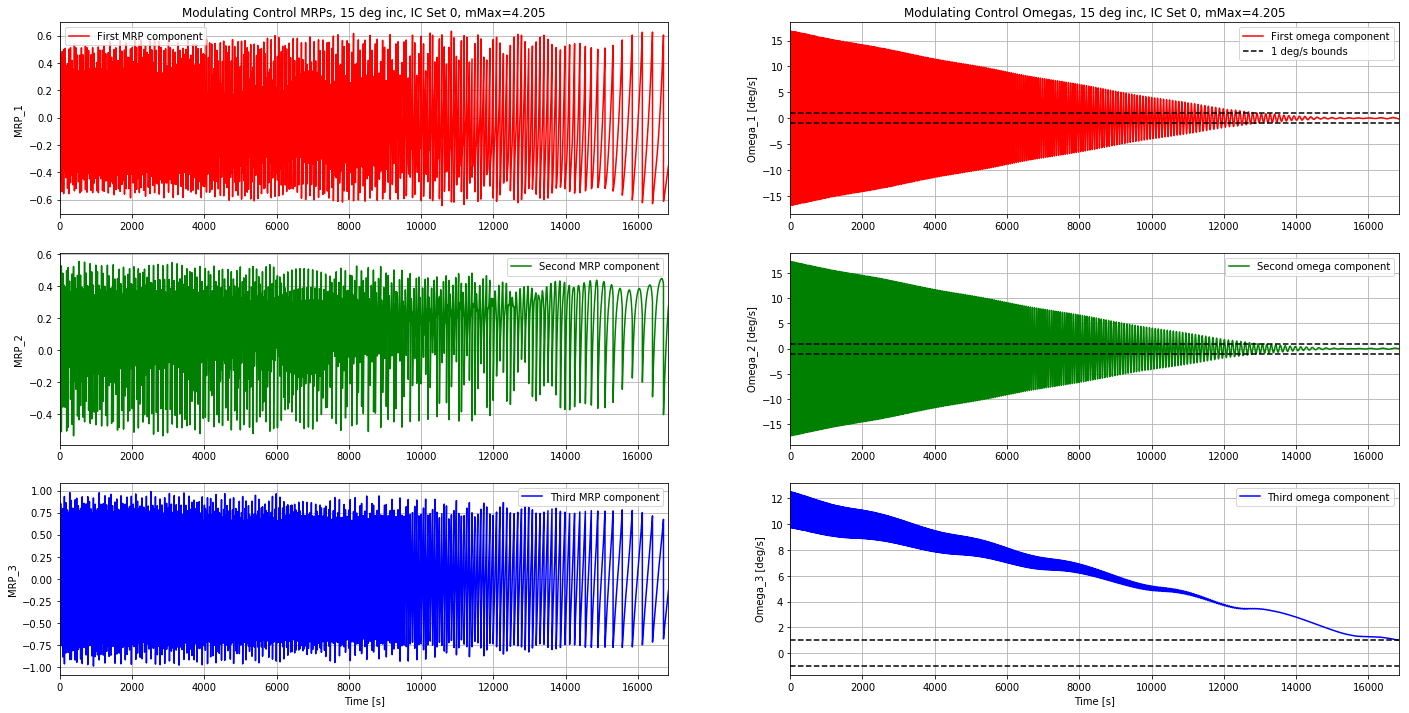

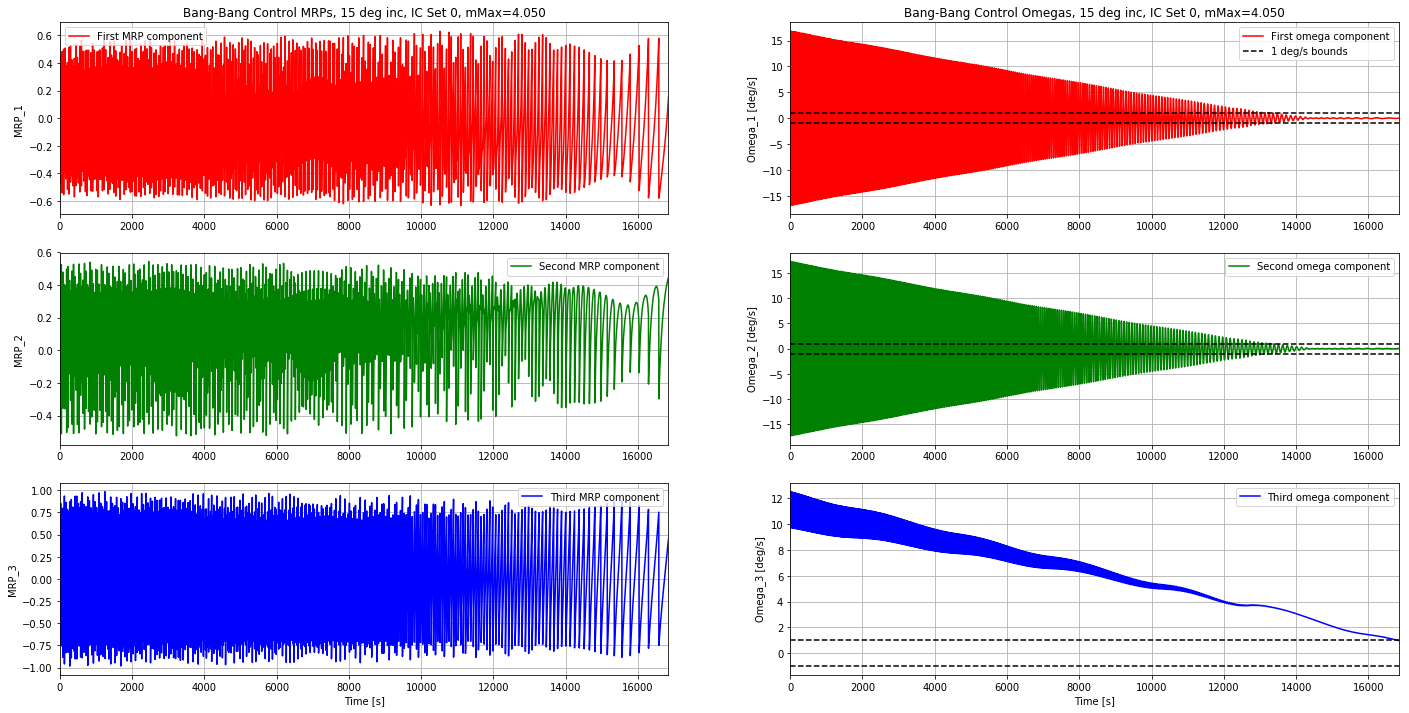

In [261]:
# 5b plots

tSpan = [0, 3*orbitPeriod]
tVec = np.arange(tSpan[0], tSpan[-1]+h, h)

mVec = [mMaxMinMod, mMaxMinBang]

for i in range(0,2):
    
    plt.figure()

    #Plot Omegas 
    plt.subplot(322)
    plt.plot(tVec, np.rad2deg(resultsPart5b[i,3,:]), 'r-', label='First omega component')
    plt.plot([0,tSpan[-1]], [1,1], 'k--', label='1 deg/s bounds')
    plt.plot([0,tSpan[-1]], [-1,-1], 'k--')
    plt.xlim([0,tSpan[-1]])
    plt.ylabel('Omega_1 [deg/s]')
    plt.legend()
    plt.grid()
    plt.title(controlTypes[i]+' Omegas, 15 deg inc, IC Set 0, mMax=%1.3f'%(mVec[i]))
    plt.subplot(324)
    plt.plot(tVec, np.rad2deg(resultsPart5b[i,4,:]), 'g-', label='Second omega component')
    plt.plot([0,tSpan[-1]], [1,1], 'k--')
    plt.plot([0,tSpan[-1]], [-1,-1], 'k--')
    plt.xlim([0,tSpan[-1]])
    plt.ylabel('Omega_2 [deg/s]')
    plt.legend()
    plt.grid()
    plt.subplot(326)
    plt.plot(tVec, np.rad2deg(resultsPart5b[i,5,:]), 'b-', label='Third omega component')
    plt.plot([0,tSpan[-1]], [1,1], 'k--')
    plt.plot([0,tSpan[-1]], [-1,-1], 'k--')
    plt.xlim([0,tSpan[-1]])
    plt.ylabel('Omega_3 [deg/s]')
    plt.xlabel('Time [s]')
    plt.legend()
    plt.grid()

    #Plot MRPs
    plt.subplot(321)
    plt.plot(tVec, (resultsPart5b[i,0,:]), 'r-', label='First MRP component')
    plt.xlim([0,tSpan[-1]])
    plt.ylabel('MRP_1')
    plt.legend()
    plt.grid()
    plt.title(controlTypes[i]+' MRPs, 15 deg inc, IC Set 0, mMax=%1.3f'%(mVec[i]))
    plt.subplot(323)
    plt.plot(tVec, (resultsPart5b[i,1,:]), 'g-', label='Second MRP component')
    plt.xlim([0,tSpan[-1]])
    plt.ylabel('MRP_2')
    plt.legend()
    plt.grid()
    plt.subplot(325)
    plt.plot(tVec, (resultsPart5b[i,2,:]), 'b-', label='Third MRP component')
    plt.xlim([0,tSpan[-1]])
    plt.ylabel('MRP_3')
    plt.xlabel('Time [s]')
    plt.legend()
    plt.grid()
    
    plt.savefig(controlTypes[i]+'States15_IC0_mMax%1.3f.png'%(mVec[i]), bbox_inches='tight')

### Monte Carlo

In [256]:
# Create Random ICs, Setup Stuff, and Arrays to Store Results

# Number of Monte Carlo runs
nRuns = 25 

ICsMod = np.empty((6,nRuns))
ICsBang = np.empty((6,nRuns))

# Generate random initial omegas
# Note: uses overview ICs for MRPS
for i in range(0,nRuns):
    ICsMod[:,i] = np.concatenate((MRP0, np.deg2rad(np.random.randint(10, high=17, size=3))), axis=0)
    ICsBang[:,i] = np.concatenate((MRP0, np.deg2rad(np.random.randint(10, high=17, size=3))), axis=0)

tSpan = [0, 5*orbitPeriod]
h = 1 # time step, [s]
tVec = np.arange(tSpan[0], tSpan[-1]+h, h)
    
monteCarloResultsMod = np.empty((6,len(tVec),nRuns))
monteCarloResultsBang = np.empty((6,len(tVec),nRuns))

mMax = 4

controlParams = [omegaE, orbitRAAN, orbitInc, theta_t0, thetaDot, orbitRad, scInertia_B, beta0, gammaM, M]

controlFuncMod = lambda t, X: modulatingBDot(t, X, mMax, controlParams)
controlFuncBang = lambda t, X: bangBangBDot(t, X, mMax, controlParams)

odefuncMod = lambda t, X: fullAttitudeDEControl(t, X, [scInertia_B, externalTorque], controlFuncMod)
odefuncBang = lambda t, X: fullAttitudeDEControl(t, X, [scInertia_B, externalTorque], controlFuncBang)

In [257]:
%%time

# Monte Carlo Runs

for i in range(0,nRuns):
    
    monteCarloResultsMod[:,:,i] = RK4Attitude(odefuncMod, ICsMod[:,i], tSpan, h)
    monteCarloResultsBang[:,:,i] = RK4Attitude(odefuncBang, ICsBang[:,i], tSpan, h)

CPU times: user 32min 53s, sys: 1.13 s, total: 32min 54s
Wall time: 32min 55s


In [263]:
%%time

tSpan = [0, 5*orbitPeriod]
h = 1 # time step, [s]
tVec = np.arange(tSpan[0], tSpan[-1]+h, h)

# Compute norms

# Arrays to save norms
omegaNormsMod = np.empty((len(tVec),nRuns))
omegaNormsBang = np.empty((len(tVec),nRuns))

# Settling times
setTimesMod = np.empty((nRuns))
setTimesBang = np.empty((nRuns))

for i in range(0,nRuns):
    setTimeModFound = False
    setTimeBangFound = False
    for j in range(0,len(tVec)):
        omegaNormsMod[j,i] = np.linalg.norm(np.rad2deg(monteCarloResultsMod[3:6,j,i]))
        omegaNormsBang[j,i] = np.linalg.norm(np.rad2deg(monteCarloResultsBang[3:6,j,i]))
        
        # Check for 3 deg/s threshold crossing
        if (np.rad2deg(omegaNormsMod[j,i])<=3):
            setTimeModFound = True
            setTimesMod[i] = tVec[j]
        if (np.rad2deg(omegaNormsBang[j,i])<=3):
            setTimeBangFound = True
            setTimesBang[i] = tVec[j]
            
# Average over runs to find avg settling time
setTimeAvgMod = np.nanmean(setTimesMod)
setTimeAvgBang = np.nanmean(setTimesBang)

CPU times: user 7.13 s, sys: 88.4 ms, total: 7.22 s
Wall time: 7.15 s


In [266]:
print(setTimeAvgMod)
print(setTimeAvgBang)

14599.52
15834.246541176468


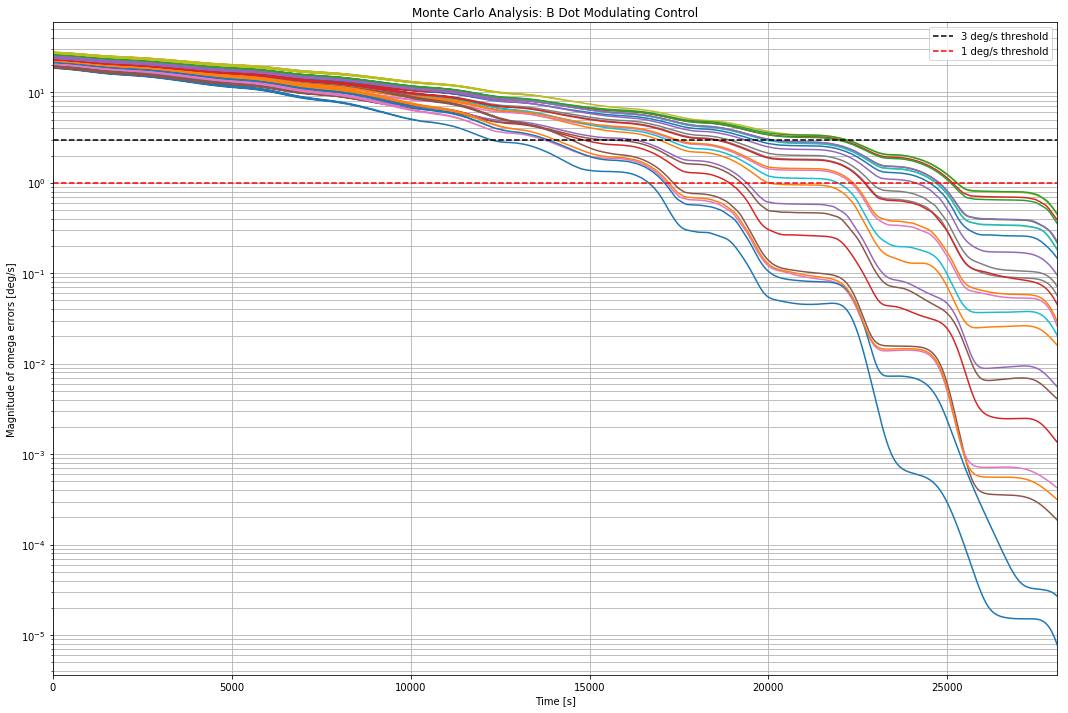

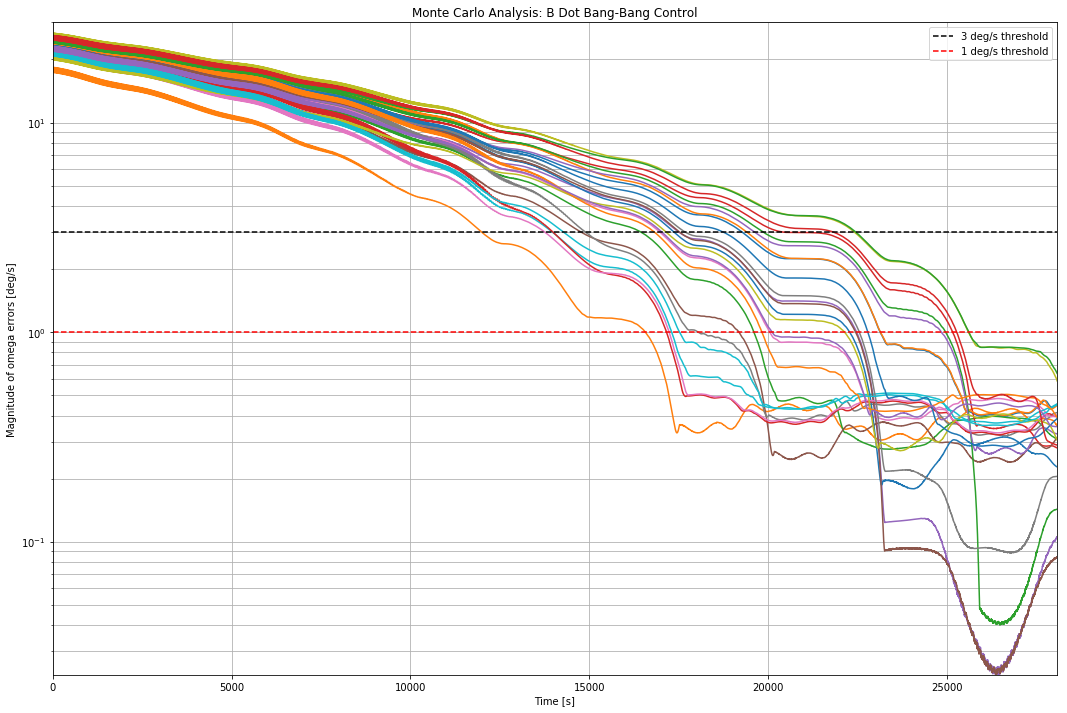

In [259]:
# Monte Carlo Plots

# Plot Omega Norms - Mod Control
plt.figure(figsize=(18,12))
for i in range(0,nRuns):
    plt.semilogy(tVec, omegaNormsMod[:,i])
    
plt.semilogy([0,tVec[-1]],[3,3], 'k--',label='3 deg/s threshold')
plt.semilogy([0,tVec[-1]],[1,1], 'r--',label='1 deg/s threshold')
plt.xlim([0,tVec[-1]])
plt.xlabel('Time [s]')
plt.ylabel('Magnitude of omega errors [deg/s]')
plt.title('Monte Carlo Analysis: B Dot Modulating Control')
plt.legend()
plt.grid(True, which='both')

# Save fig
plt.savefig('MonteCarloMod5.png', bbox_inches='tight')

plt.show()

# Plot Omega Norms - Bang-Bang Control
plt.figure(figsize=(18,12))
for i in range(0,nRuns):
    plt.semilogy(tVec, omegaNormsBang[:,i])
    
plt.semilogy([0,tVec[-1]],[3,3], 'k--',label='3 deg/s threshold')
plt.semilogy([0,tVec[-1]],[1,1], 'r--',label='1 deg/s threshold')
plt.xlim([0,tVec[-1]])
plt.ylim([0,30])
plt.xlabel('Time [s]')
plt.ylabel('Magnitude of omega errors [deg/s]')
plt.title('Monte Carlo Analysis: B Dot Bang-Bang Control')
plt.legend()
plt.grid(True, which='both')

# Save fig
plt.savefig('MonteCarloBang5.png', bbox_inches='tight')

plt.show()